### Preparing the target..

In [1]:
# Defining target for ZeMA dataset. 
# Target is vector with numbers from 0 to 100 which represent degree of wear.

def zemaTarget(sensors):
    target=list(np.zeros(sensors[0].shape[1]))          # Making the target list which takes into account number of cycles, which-
    for i in range(sensors[0].shape[1]):                # goes from 0 to 100, and has number of elements same as number of cycles. 
        target[i]=(i/(sensors[0].shape[1]-1))*100
    return(target)

### Spliting the raw ZeMA data into training and testing sets.

In [2]:
def splitZemaData(sensors, target):

    k = int(input("Enter the percentage which will be used as a traning data (recommended is 80-90): "))
    target_train, target_test =train_test_split(pd.DataFrame(target), test_size=1-k/100.)

    print("\nNumber of cycles selected for traning is: ", target_train.shape[0],",")
    print("and number of cycles selected for testing is: ", target_test.shape[0])

    sensors_train=[0]*len(sensors)
    sensors_test=[0]*len(sensors)

    for i in range(len(sensors)):
        sensors_train[i]=sensors[i].loc[:,target_train.index]

    print("\n\nTraning data for one sensor has dimensions: ", sensors_train[0].shape,",      ('sensor_train') ")
    print("and it's target vector has length: ", target_train.shape,",                      ('target_train') \n")

    for i in range(len(sensors)):
        sensors_test[i]=sensors[i].loc[:,target_test.index]

    print("Testing data for one sensor has dimensions: ", sensors_test[0].shape,",      ('sensor_test') ")
    print("and it's target vector has length: ", target_test.shape,",                   ('target_test') \n")
    
    return sensors_train, sensors_test, target_train, target_test;

### Training functions..

In [3]:
def chooseAndReturnOrdered(sensor, timestep, N, verbose=False):
    
    n_of_samples=sensor.shape[0]
    
    # Fast Fourier transform
    freq = np.fft.rfftfreq(n_of_samples, timestep)       # Frequency axis, can be used for ploting in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor,n_of_samples,0)  # Ndarray of amplitudes after fourier transform.
    
    # Transforming amplitudes into data frame (matrix)-
    # -where one column represents amplitudes of one-
    # -cycle.
    fft_matrix = pd.DataFrame(fft_amplitudes)            
    
    # Transposing to matrix where rows are cycles.
    fft_matrix=fft_matrix.transpose()                     

    n_rows, n_columns = np.shape(fft_matrix)
    
    if verbose:
        print("\nNumber of cycles is: %s, and number of features after fft is: %s" % (n_rows, n_columns))

    # Index labels are cycle numbers.
    fft_matrix.index=sensor.columns
    
    # Column labels are frequencies.
    fft_matrix.columns = freq                             

    # Calculating the average of absolute vales for each frequency (column).
    absolute_average_values_from_columns=(np.abs(fft_matrix)).mean()

    # Sorting the fft_matrix by the average of absolute vales for each frequency (column).
    fft_matrix=fft_matrix.reindex((np.abs(fft_matrix)).mean().sort_values(ascending=False).index, axis=1)

    # Taking first N percent columns from sorted fft_matrix. 
    sorted_ampl_with_freq=fft_matrix.iloc[:,:round((N/100.0)*len(freq))]

    n_rows, n_columns = np.shape(sorted_ampl_with_freq)
    
    if verbose:
        print("\nNumber of cycles is: %s, and number of selected features is: %s" % (n_rows, n_columns))
        print("---------------------------------------------------------------------------------\n")

    return  sorted_ampl_with_freq;

In [4]:
def chooseFromListOfMatrices (sensors, timestep, N, verbose=False):
    list_of_sorted_ampl_with_freq=[0]*len(sensors)
    
    for i in range(len(sensors)):
        
        if verbose:
            print("Sensor number %s" % i)
            print("---------------------------------------------------------------------------------")
            
        list_of_sorted_ampl_with_freq[i]=chooseAndReturnOrdered(sensors[i], timestep, N, verbose)
    return list_of_sorted_ampl_with_freq;

In [5]:
def findPearsonIndices(list_of_sorted_ampl_with_freq, target_train, n_of_top_features, verbose=False):
    
    n_features_for_select=0
    for i in range(len(list_of_sorted_ampl_with_freq)):
        n_features_for_select=n_features_for_select+int(len(list_of_sorted_ampl_with_freq[i].iloc[0][:]))

    if verbose:
        print("\nDimension of target is:")
        print("                                                 ", target_train.shape)
        print("Dimension of amplitude matrix for one sensor is:")
        print("                                                 ", list_of_sorted_ampl_with_freq[0].iloc[:][:].shape)
    
    # Making list for correlation coefficients.
    corr=list(range(len(list_of_sorted_ampl_with_freq)))          
    p_value=list(range(len(list_of_sorted_ampl_with_freq)))
    
    # Making sublists in "corr" for each sensor.
    for j in range(len(list_of_sorted_ampl_with_freq)):               
        corr[j]=list(range(list_of_sorted_ampl_with_freq[j].shape[1]))
        p_value[j]=list(range(list_of_sorted_ampl_with_freq[j].shape[1]))

    # Calculating correlation coefficients for each column of each sensor with respect to target.
    for j in range(len(list_of_sorted_ampl_with_freq)):
        for i in range(list_of_sorted_ampl_with_freq[j].shape[1]):
            corr[j][i],p_value[j][i]=pearsonr(np.abs(list_of_sorted_ampl_with_freq[j].iloc[:,i]),target_train[0])
    
    # Transforming list of correlation coefficients to nparray
    corr_array=np.array(corr) 
    
    if verbose:
        print("Array of correlation coefficients has size:")
        print("                                                 ",corr_array.shape)  

    def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
        """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
        flat = array.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        return np.unravel_index(indices, array.shape)  

    # sensor_n is the index of the sensor number.
    # feature_n is the index of the feature number for each sensor number.
    sensor_n, feature_n = largest_indices(corr_array,  n_of_top_features)
    
    if verbose:
        print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
        print(sensor_n)
        print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
        print(feature_n)

    return sensor_n, feature_n;

In [6]:
# This function uses indices from sensor_n and feature_n to extract features from list_of_sorted_ampl_with_freq.

def extractTopN(list_of_sorted_ampl_with_freq, sensor_n, feature_n, verbose=False):
    top_n_features=[0]*len(list_of_sorted_ampl_with_freq)
    
    for i in range(len(list_of_sorted_ampl_with_freq)):
        top_n_features[i]=[]
    
    for i in range(len(list_of_sorted_ampl_with_freq)):
        for j in range(len(sensor_n)):
            if sensor_n[j]==i:
                top_n_features[i].append(list_of_sorted_ampl_with_freq[i].iloc[:,feature_n[j]]);

    for i in range(len(list_of_sorted_ampl_with_freq)):
        for j in range(len(top_n_features[i])):
            top_n_features[i][j]=list(top_n_features[i][j])

    # Merging sublists into one list with all elements.
    top_n_together=[j for i in top_n_features for j in i]  

    top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
    
    if verbose:
        print(type(top_n_together_matrix), "\n")

    # Continue working with abosulte values.
    abs_top_n_features=np.abs(top_n_together_matrix)

    percentage=list(range(len(list_of_sorted_ampl_with_freq)))
    k=0
    for i in range(len(list_of_sorted_ampl_with_freq)):
        if verbose:
            print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_n)*100))
        percentage[i]=len(top_n_features[i])
        k=k+len(top_n_features[i])/len(sensor_n)*100
    
    if verbose:
        print("----------------------------------------------------")
        print("                                             %4.2f" % (k))

    labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
    if verbose:
        print("Percentages of features from each sensor are:")
    
    if verbose:
        fig1, ax1 = plt.subplots(figsize=(8,8))
        ax1.pie(percentage, labels=labels[:len(list_of_sorted_ampl_with_freq)], autopct='%1.1f%%', shadow=True, startangle=90, )
        ax1.axis('equal')
        plt.show()
    
    return abs_top_n_features

### Applying extraction patterns to testing data.

In [7]:
#Extracting features from test data with predefined frequencies.

def extractFromTesting(sensor_test, sorted_ampl_with_freq, timestep, verbose=False):
    
    n_of_samples=sensor_test.shape[0]
    
    # Fast Fourier transform
    freq = np.fft.rfftfreq(n_of_samples, timestep)            # Frequency axis, can be used for ploting in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor_test,n_of_samples,0)  # Ndarray of amplitudes after fourier transform.
  
    fft_matrix = pd.DataFrame(fft_amplitudes)             
                                                          
    fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.

    n_rows, n_columns = np.shape(fft_matrix)
    
    if verbose:
        print("\nNumber of cycles is: %s, and number of features is: %s \n" % (n_rows, n_columns))
    fft_matrix.columns = freq                    # Column labels are frequencies.
    
    if verbose:
        print("Frequencies are the same as in the traning data, of course. \nFirst 10 of them:\n\n %s" % sorted_ampl_with_freq.columns.values[:10])
    
    amplitudes_from_test=fft_matrix.loc[:, sorted_ampl_with_freq.columns.values]

    n_rows, n_columns = np.shape(amplitudes_from_test)
    
    if verbose:
        print("\nNumber of cycles is: %s, and number of selected features is: %s \n\n" % (n_rows, n_columns))
    
    return amplitudes_from_test;

In [8]:
def extractFromListOfTestingMatrices (sensors_test,list_of_sorted_ampl_with_freq, timestep, verbose=False):

    list_of_sorted_ampl_test=[0]*len(sensors_test)
    
    for i in range(len(sensors_test)):         
        if verbose:
            print("Sensor number %s" % i)
            print("---------------------------------------------------------------------------------")
        list_of_sorted_ampl_test[i]=extractFromTesting(sensors_test[i], list_of_sorted_ampl_with_freq[i], timestep, verbose)
    
    return list_of_sorted_ampl_test;

In [9]:
def LDA_Classify(abs_top_n_features, abs_top_n_test_features, target_train, target_test, verbose=False):
    
    # Definition of new target with rounding to first higher number.
    class_target_train=np.ceil(target_train[0])

    for i in class_target_train.index:
        if class_target_train[i]==0:
            class_target_train[i]=1                #Fixing the zero element.
    
    # Clustering the testing data target vector for comparing and error calculation.  
    class_target_test=np.ceil(target_test[0])

    for i in class_target_test.index:
        if class_target_test[i]==0:
            class_target_test[i]=1
    
    X_train = np.array(abs_top_n_features)          # Feature matrix.
    y_train = np.array(class_target_train)          # Target vector.
    
    if verbose:
        print("Training set:\n")
        print(X_train.shape)
        print(y_train.shape)

    X_test = np.array(abs_top_n_test_features)      # Feature matrix.
    y_test = np.array(class_target_test)            # Target vector.
    
    if verbose:
        print("\nTesting set:\n")
        print(X_test.shape)
        print(y_test.shape)
    
    LDA1 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='eigen')
 
    Y_train=LDA1.fit_transform(X_train,y_train)
    Y_test=LDA1.transform(X_test)
    
    score=LDA1.score(X_test, y_test)
    y_predicted=LDA1.predict(X_test)
    
    if verbose:
        print("Overall score of LDA predict is: %s" % score)
    
    if verbose:
        plt.figure(figsize=(20,20))
        plt.subplot(221)
        plt.scatter(y_test, LDA1.predict(X_test))
        plt.xlabel("Real class", size='18')
        plt.ylabel("Predicted class", size='18')
    
        plt.subplot(223)
        plt.title("First two disriminant functions with correct label",fontsize=18)
        plt.scatter(Y_test[:,0], Y_test[:,1], c=y_test, cmap="viridis")                   
        plt.xlabel("First discriminant function", fontsize=15)
        plt.ylabel("Second discriminant function", fontsize=15)

        plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)
    
        plt.subplot(224)
        plt.title("First two disriminant functions with predicted labels",fontsize=18)
        plt.scatter(Y_test[:,0], Y_test[:,1], c=LDA1.predict(X_test), cmap="viridis")                   
        plt.xlabel("First discriminant function", fontsize=15)
        plt.ylabel("Second discriminant function", fontsize=15)
        plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)
    
    return y_test, y_predicted, score 

In [10]:
def Regression(abs_top_n_features, abs_top_n_test_features, target_train, target_test, regression_model, verbose=False):
    
    X_train = np.array(abs_top_n_features)          # Feature matrix.
    y_train = np.array(target_train[0])          # Target vector.
    
    if verbose:
        print("Training set:\n")
        print(X_train.shape)
        print(y_train.shape)
    
    
    X_test = np.array(abs_top_n_test_features)      # Feature matrix.
    y_test = np.array(target_test[0])                  # Target vector.
    if verbose:
        print("\nTesting set:\n")
        print(X_test.shape)
        print(y_test.shape)
    
    if regression_model=="BayesianRidge":
        lm = linear_model.BayesianRidge()
    elif regression_model=="RandomForest":
        lm = RandomForestRegressor(n_estimators=40)
    else:
        raise Exception("Wronly defined regression model. Available models are: 'RandomForest' and 'BayesianRidge'")
        
    lm.fit(X_train,y_train)
    
    score=lm.score(X_test, y_test)
    
    y_predicted=lm.predict(X_test)
    
    
    for i in range(len(y_predicted)):
        if y_predicted[i]>100:
            y_predicted[i]=100
        elif y_predicted[i]<0:
            y_predicted[i]=0

    if verbose:
        print("Overall score of RF predict is: %s" % score)
    
        plt.figure(figsize=(10,10))
    
        plt.scatter(y_test, y_predicted)
        plt.xlabel("Real class", size='18')
        plt.ylabel("Predicted class", size='18')
    
    return y_test, y_predicted, score 

# Workflow

In [11]:
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model

### Importing the data

In [12]:
filename = '../Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                        # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(len(data)):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(len(data)):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]        # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))


    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
    and 6291 represents number of cycles.


### Creating a target

In [16]:
target=zemaTarget(sensorADC)

### Splitting the dataset..

In [17]:
sensors_train, sensors_test, target_train, target_test=splitZemaData(sensorADC, target)

Enter the percentage which will be used as a traning data (recommended is 80-90): 80

Number of cycles selected for traning is:  5032 ,
and number of cycles selected for testing is:  1259


Traning data for one sensor has dimensions:  (2000, 5032) ,      ('sensor_train') 
and it's target vector has length:  (5032, 1) ,                      ('target_train') 

Testing data for one sensor has dimensions:  (2000, 1259) ,      ('sensor_test') 
and it's target vector has length:  (1259, 1) ,                   ('target_test') 



# Note:

### For using LDA, minimum number of cycles in traning data (instances) is 600. Reason for this is unknown, maybe it is beacuse of number of features that are used and some specific things in algorithm. For other methods smaller number of cycles can be used for traning data.

# Traning...

###### Function input: 

**- traning data from senzors**: **`sensors_train`**: list of DataFrame-s, shape `(n_points_in_measurement_cycle, n_measurement_cycles (instances)`. Each DataFrame in list is data from one of 11 sensors used for measurement.

**- training data target**: **`target_train`** : DataFrame, shape `(n_measurement_cycles (instances), 1)`. Indexes in this DataFrame are cycle numbers.

**-** timestep between measurements  `timestep` (default=0.005).  

**-** percentage of frequencies after fast Fourier transform `N` (default=10).

**-** final number of features used for prediction `n_of_features` (default=500).

Function does fast Fourier transform and chooses N% of sprectrum with highest average of absolute values for each sensor independently. Average of absolute values for one frequency is calculated through all cycles. After that, Pearson correlation factor is calculated for all choosen features, and amount of best features out of these is selected for prediction.

###### Function returns:

- `traning_features` : DataFrame, shape `(n_measurement_cycles (instances), n_of_features)`
- `list_of_sorted_ampl_with_freq` : list of DataFrames with information for prediction
- `sensor_indices`, array of indices used for extraction from testing data
- `feature_indices`, array of indices used for extraction from testing data




In [18]:
def train(sensors_train, target_train, timestep=0.005, percentage_of_frequencies=10, n_of_features=500, verbose=False):
    
    list_of_sorted_ampl_with_freq=chooseFromListOfMatrices(sensors_train, timestep, percentage_of_frequencies, verbose)
    sensor_indices, feature_indices = findPearsonIndices(list_of_sorted_ampl_with_freq, target_train, n_of_features, verbose)
    traning_features=extractTopN(list_of_sorted_ampl_with_freq, sensor_indices, feature_indices, verbose)

    return traning_features, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices;

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 5032, and number of features after fft is: 1001

Number of cycles is: 5032, and number of selected features is: 100
---------------------------------------------------------------------------------

Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 5032, and number of features after fft is: 1001

Number of cycles is: 5032, and number of selected features is: 100
---------------------------------------------------------------------------------

Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 5032, and number of features after fft is: 1001

Number of cycles is: 5032, and number of selected features is: 100
---------------------------------------------------------------------------------

Sensor number 3
---------------------------

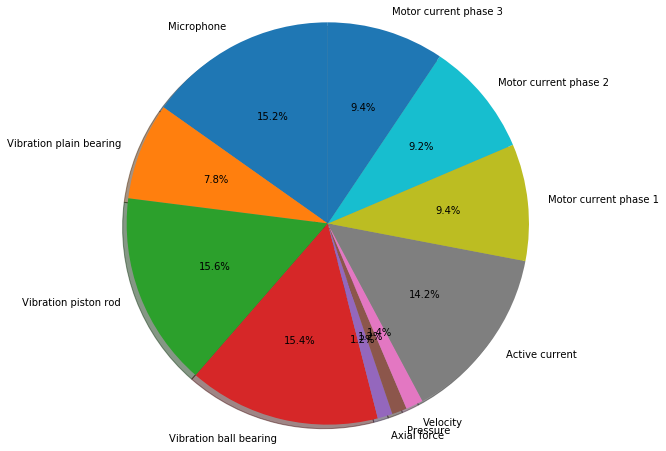

In [26]:
traning_features, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices=train(sensors_train, target_train, verbose=True)

# Prediction...

### Inputs for next two functions: 

**- testing data from senzors**: **`sensors_test`**: list of DataFrame-s, shape `(n_points_in_measurement_cycle, n_measurement_cycles (instances)`. Each DataFrame in list is data from one of 11 sensors used for measurement.

**- testing data target**: **`target_test`** : DataFrame, shape `(n_measurement_cycles (instances), 1)`. Indexes in this DataFrame are cycle numbers.

**-** features selected from traning data: `traning_features`

**- training data target**: **`target_train`** : DataFrame, shape `(n_measurement_cycles (instances), 1)`. Indexes in this DataFrame are cycle numbers.

**-** `list_of_sorted_ampl_with_freq` : list of DataFrames with information for prediction. Output from previous function.

**-** `sensor_indices`, array of indices used for extraction from testing data. Output from previous function.

**-** `feature_indices`, array of indices used for extraction from testing data. Output from previous function.
                                                                            
**-** timestep between measurements  `timestep` (default=0.005).  

**-** percentage of frequencies after fast Fourier transform `N` (default=10).

**-** final number of features used for prediction `n_of_features` (default=500).

plus for regression:

**-**  `regression_model` (`'BayesianRidge'` or `'RandomForest'`).


### Functions return:

**`real`** - array of correct target values, 

**`predicted`** - array of correct target values, 

**`score`**- score of the method used for prediction.

After using `predictLDA()`, arrays real and predicted are integers from 0 to 100, becauese we used classification methods where classes are integers. 

After using `predictReg()`, arrays real and predicted are floats from 0 to 100 because regression was used. 

In [21]:
def predictLDA(sensors_test, target_test, traning_features, target_train, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices, timestep=0.005, verbose=False):
    list_of_sorted_ampl_test=extractFromListOfTestingMatrices (sensors_test, list_of_sorted_ampl_with_freq, timestep, verbose)
    abs_top_n_test_features=extractTopN(list_of_sorted_ampl_test, sensor_indices, feature_indices, verbose)
    real, predicted, score=LDA_Classify(traning_features, abs_top_n_test_features, target_train, target_test, verbose)
    return real, predicted, score;

In [22]:
def predictReg(sensors_test, target_test, traning_features, target_train, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices, timestep, regression_model, verbose=False):
    list_of_sorted_ampl_test=extractFromListOfTestingMatrices (sensors_test, list_of_sorted_ampl_with_freq, timestep, verbose)
    abs_top_n_test_features=extractTopN(list_of_sorted_ampl_test, sensor_indices, feature_indices, verbose)
    real, predicted, score=Regression(traning_features, abs_top_n_test_features, target_train, target_test, regression_model, verbose)
    return real, predicted, score;

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [ 0.  48.   8.5  0.1 64.  10.   0.2 12.   0.3  0.6]

Number of cycles is: 1259, and number of selected features is: 100 


Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [48.   8.  47.9  7.9  0.2 48.1  7.8  0.   4.  12. ]

Number of cycles is: 1259, and number of selected features is: 100 


Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [16.1 16.2 12.  16.  16.3 40.6 

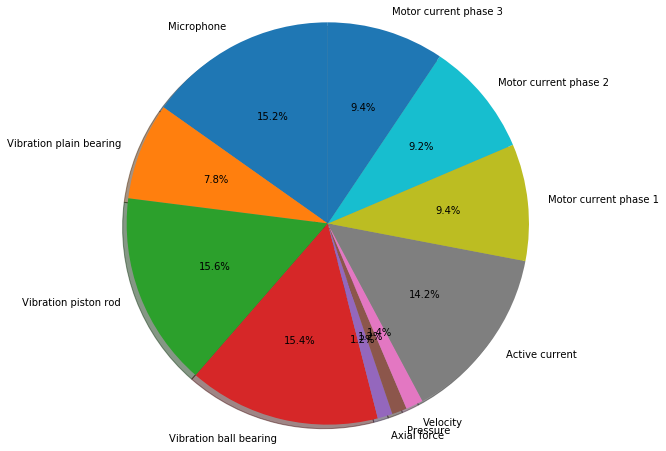

Training set:

(5032, 500)
(5032,)

Testing set:

(1259, 500)
(1259,)
Overall score of LDA predict is: 0.8284352660841938


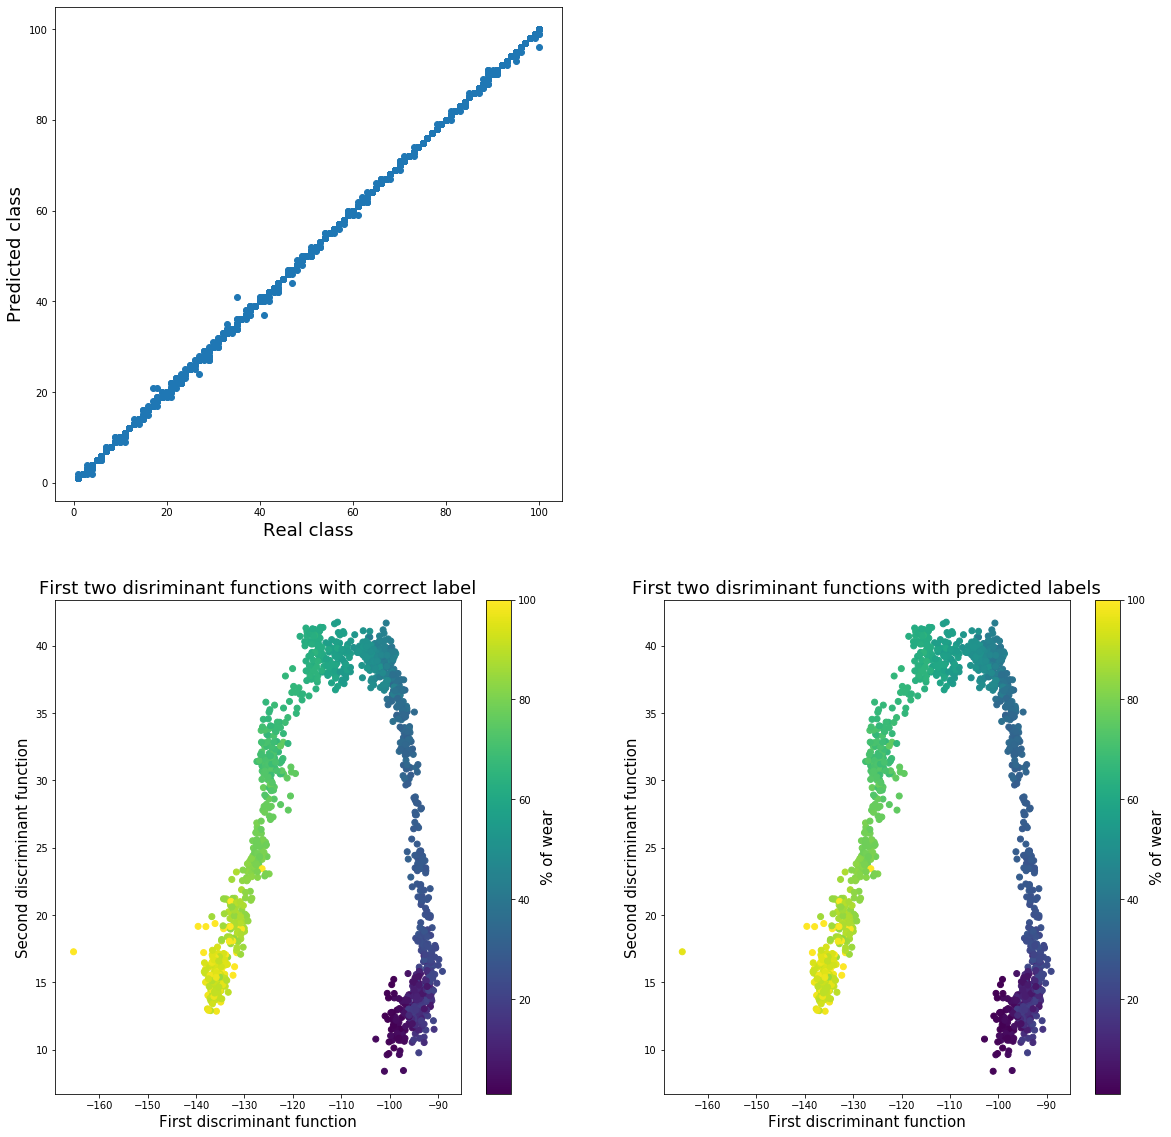

In [23]:
realLDA, predictedLDA, scoreLDA=predictLDA(sensors_test, target_test, traning_features, target_train, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices, verbose=True)

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [ 0.  48.   8.5  0.1 64.  10.   0.2 12.   0.3  0.6]

Number of cycles is: 1259, and number of selected features is: 100 


Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [48.   8.  47.9  7.9  0.2 48.1  7.8  0.   4.  12. ]

Number of cycles is: 1259, and number of selected features is: 100 


Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [16.1 16.2 12.  16.  16.3 40.6 

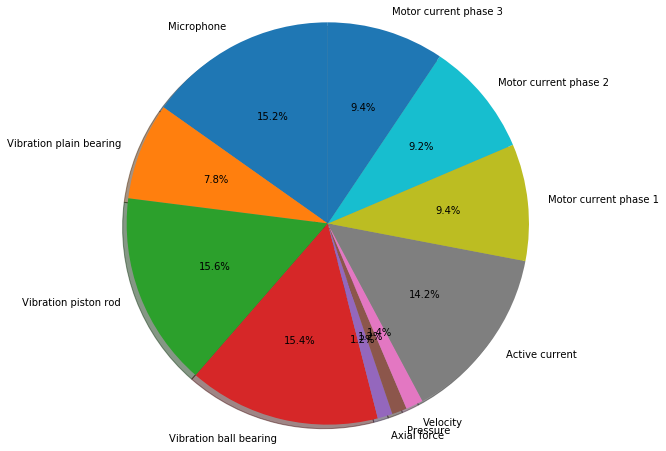

Training set:

(5032, 500)
(5032,)

Testing set:

(1259, 500)
(1259,)
Overall score of RF predict is: 0.9790914754037281


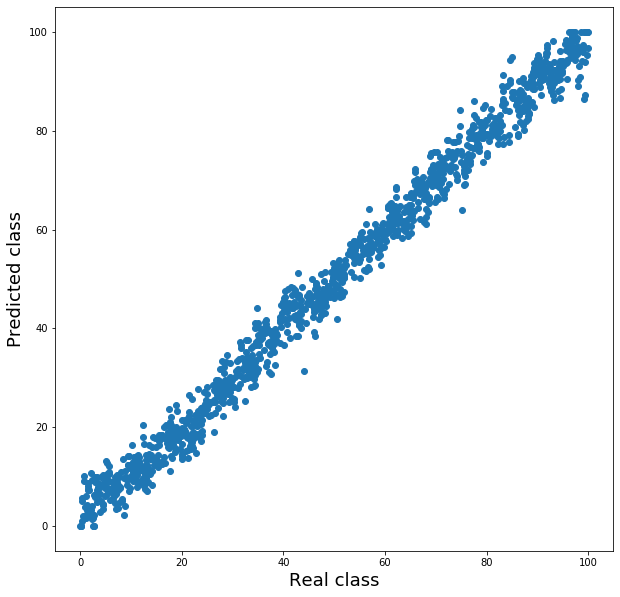

In [24]:
realBR, predictedBR, scoreBR=predictReg(sensors_test, target_test, traning_features, target_train, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices, 0.005, 'BayesianRidge', verbose=True)

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [ 0.  48.   8.5  0.1 64.  10.   0.2 12.   0.3  0.6]

Number of cycles is: 1259, and number of selected features is: 100 


Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [48.   8.  47.9  7.9  0.2 48.1  7.8  0.   4.  12. ]

Number of cycles is: 1259, and number of selected features is: 100 


Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 1259, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [16.1 16.2 12.  16.  16.3 40.6 

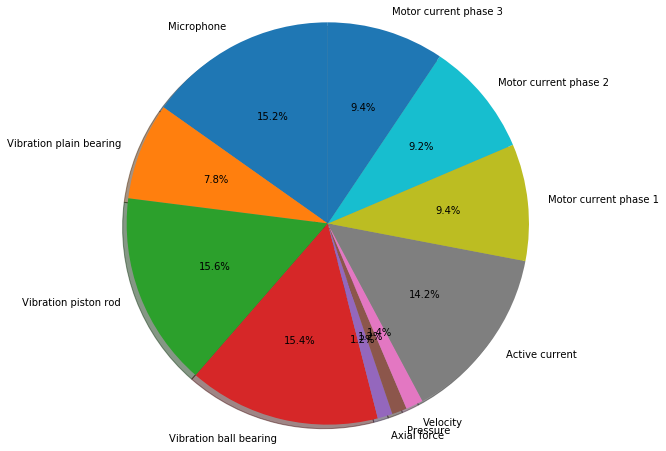

Training set:

(5032, 500)
(5032,)

Testing set:

(1259, 500)
(1259,)
Overall score of RF predict is: 0.9971617103043401


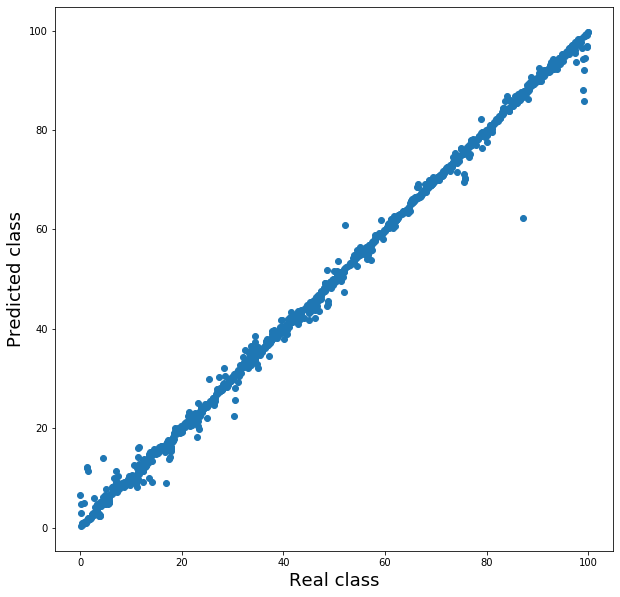

In [25]:
realRF,predictedRF,scoreRF=predictReg(sensors_test, target_test, traning_features, target_train, list_of_sorted_ampl_with_freq, sensor_indices, feature_indices, 0.005, "RandomForest", verbose=True)